In [1]:
import numpy as np
import pandas as pd
import random
import datetime
import matplotlib.pyplot as plt
startTime = datetime.datetime.now()
data = pd.read_csv('weatherAUS.csv', header = 0)
data = data.drop(columns = 'Date').replace('Yes',1).replace('No',0).replace('N',1).replace('NNE',2).replace('NE',3).replace('ENE',4).replace('E',5).replace('ESE',6).replace('SE',7).replace('SSE',8).replace('S',9).replace('SSW',10).replace('SW',11).replace('WSW',12).replace('W',13).replace('WNW',14).replace('NW',15).replace('NNW',16)
df = {}
Y = {}
t_df = {}
t_Y = {}
lastKey = data.iloc[0]['Location']
begin = 0
for i in range(1,len(data)):
    if data.iloc[i]['Location']!= lastKey:
        df[lastKey] = data.drop(columns = 'Location').iloc[begin: i]
        begin, lastKey = i, data.iloc[i]['Location']
df[lastKey] = data.drop(columns = 'Location').iloc[begin: len(data)]

In [2]:
for key in df:
    for col in df[key].columns:
        if np.mean(df[key][col].isnull())*100 > 40:
            df[key].drop(col, axis=1 ,inplace=True)
            #print(key +" "+ col)
    i = 0
    for k in range(len(df[key])):
        if df[key].iloc[i].isna().sum() > 3:
            df[key].drop(df[key].index[i], inplace = True)
            i-=1
            k+=1
        i+=1
    for col in df[key].columns:
        df[key][col].fillna(df[key][col].mean(), inplace = True)
        df[key][col] = df[key][col]/np.max(df[key][col])
    test_num = int(len(df[key]) * 0.8)
    Y[key] = df[key]['RainTomorrow']
    df[key].drop('RainTomorrow', axis = 1, inplace = True)
    t_Y[key] = Y[key].iloc[test_num:len(Y[key])]
    Y[key].drop(Y[key].index[test_num:len(Y[key])], axis = 0, inplace = True)
    t_df[key] = df[key].iloc[test_num:len(df[key])]
    df[key].drop(df[key].index[test_num:len(df[key])], axis = 0, inplace = True)
            

In [3]:
def sigmoid(x):
    return np.exp(x)/(1+np.exp(x))

In [4]:
def score(bias,weights,features):
    return np.dot(weights,features).sum()+ bias

In [5]:
def prediction(bias, weights,features):
    return sigmoid(score(bias,weights,features))

In [6]:
def logLoss(bias,weights,features,label):
    h = prediction(bias,weights,features)
    return -label*np.log(h) - ((1-label)*np.log(1- h))

In [7]:
def totalLogLoss(bias,weights,features,labels):
    totalError = 0
    for i in range(len(features)):
        totalError+= logLoss(bias,weights,features.iloc[i],labels.iloc[i])
    return totalError

In [8]:
def logistic_shift(bias,weights,features,y, n):
    #print(features)
    h = prediction(bias,weights,features)
    for i in range(len(weights)):
        weights[i] += (n*(y-h)*features[i])
    bias += n*(y-h)
    return bias,weights

In [9]:
def logistic_regression_algo(features,labels, n, epochs, location = ''):
    #print(f"{len(features)} {len(labels)}")
    weights = np.random.rand(len(features.columns))
    bias = random.random()
    errors = []
    for _ in range(epochs):
        p = random.randint(0,len(features)-1)
        logistic_shift(bias,weights,features.iloc[p],labels.iloc[p], n)
        errors.append(totalLogLoss(bias,weights,features,labels))
    %matplotlib inline
    plt.scatter(x=range(epochs),y=errors)
    plt.xlabel(location+"- epochs")
    plt.ylabel("error")
    plt.show()
    return bias,weights

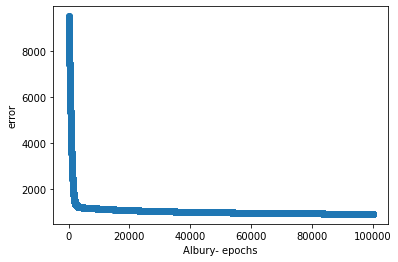

In [ ]:
vals ={}
for key in df:
    vals[key] = logistic_regression_algo(df[key],Y[key],0.001,100000,key)
#bias,weights = logistic_regression_algo(df['Albury'],Y['Albury'],0.001,100,'Albury')

In [ ]:
for key in t_df:
    Error = []
    for i in range(len(t_df[key])):
        h = vals[key][0] + np.dot(vals[key][1], t_df[key].iloc[i]).sum()
        p=0
        if h>=0.5:
            p=1
        else:
            p=0
        if p == t_Y[key].iloc[i]:
            Error.append(0)
        else:
            Error.append(np.abs(h-t_Y[key].iloc[i]))
    plt.scatter(x = range(len(t_df[key])), y = Error)
    plt.xlabel('Sample - '+ key)
    plt.ylabel('Error')
    plt.show()
endTime = datetime.datetime.now()
print(f"Total Time Taken: {endTime-startTime}")